# Super resolution project

Project implementing super resolution for scanned images to be used in text extraction applications such as Tesseract 4.

## Setup

Read libraries and functions

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [399]:
import urllib.request
import json
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import glob
import cv2

from PIL import Image
from io import BytesIO
from scipy.misc import imresize

In [3]:
PATH = '../'

Download address data

In [7]:
# All danish addresses
urllib.request.urlretrieve('http://dawa.aws.dk/adresser?format=json',
                           PATH + 'data/addresses_denmark.json')

# Copenhagen addresses
urllib.request.urlretrieve('http://dawa.aws.dk/adresser?format=json&kommunekode=0101',
                           PATH + 'data/addresses_copenhagen.json')

('../data/danmarks_adresser.json', <http.client.HTTPMessage at 0x1ee732f5e48>)

Extract address data from json

In [42]:
with open(PATH + 'data/addresses_copenhagen.json', 'rb') as f:
    json_addresses = json.loads(f.read().decode())

Extract relevant information from JSON and gather in dict with two primary lines.

In [100]:
def addr_const(in_elem):
    
    tmp_dict = {
        'road': in_elem['adgangsadresse']['vejstykke']['adresseringsnavn'],
        'number': in_elem['adgangsadresse']['husnr'],
        'floor': in_elem['etage'],
        'door': in_elem['dør'],
        'zip': in_elem['adgangsadresse']['postnummer']['nr'],
        'zip_name': in_elem['adgangsadresse']['postnummer']['navn'],
    }
    
    if tmp_dict['floor'] is not None:
        tmp_dict['floor'] = ', ' + tmp_dict['floor'] + '.'
    else:
        tmp_dict['floor'] = ''
        
    if tmp_dict['door'] is not None:
        tmp_dict['door'] = ' ' + tmp_dict['door'] + '.'
    else:
        tmp_dict['door'] = ''
        
    out_dict = {
        'road': '{tmp_dict[road]} {tmp_dict[number]}{tmp_dict[floor]}{tmp_dict[door]}'.format(tmp_dict=tmp_dict),
        'zip': '{tmp_dict[zip]} {tmp_dict[zip_name]}'.format(tmp_dict=tmp_dict)
    }
    
    return out_dict


adresses = []
for element in json_addresses:
    
    adresses.append(addr_const(element))

Save formatted address data to disk

In [104]:
with open (PATH + '/data/address_list.pkl', 'wb') as f:
    pickle.dump(addr_list, f)

Read company information

In [113]:
company_full = pd.read_csv(PATH + 'data/companies.csv', encoding = 'utf-8', low_memory = False)

companies = company_full['navn_tekst'].apply(lambda x: x.title())
companies.head(5)

companies = companies.tolist()

0                             Vognmand John Maj A/S
1             A Stoffregen Mindelegat Postboks 2231
2                    Anthon Thorup & Søn. Århus A/S
3    Finn Randrup. Tømrer- Og Snedkerforretning A/S
4                         Heka Stillads-Service A/S
Name: navn_tekst, dtype: object

Write company information to disk

In [115]:
with open (PATH + '/data/company_list.pkl', 'wb') as f:
    pickle.dump(companies, f)

## Image generation

Read companies data and logos

In [16]:
with open(PATH + '/data/company_list.pkl', 'rb') as f:
    companies = pickle.load(f)

with open(PATH + '/data/address_list.pkl', 'rb') as f:  
    addresses = pickle.load(f)

Read images

In [26]:
logo_files = glob.glob(PATH + 'data/logos/*.jpg')
logos = np.array([imresize(np.array(Image.open(f)), (150, 150)) for f in logo_files])

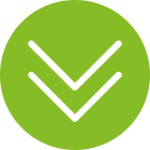

In [53]:
Image.fromarray(logos[0])

Generate images

In [430]:
class AddressGenerator:
    
    def __init__(self, companies, address, logos):
        
        self.companies = companies
        self.addresses = address
        self.logos = logos
        self.styles = ['normal', 'italic', 'oblique']
        self.weight = ['normal', 'bold']
        self.font_family = ['Tahoma', 'DejaVu Sans', 'Arial', 'Verdana', 'sans-serif', 'serif',
                            'Times New Roman', 'Courier New', 'Georgia']
        
    def sample(self, n):
        
        # Draw companies - cut name off at 30 characters
        companies_draw = np.random.choice(self.companies, n)
        for i in range(len(companies_draw)):
            companies_draw[i] = companies_draw[i][:35]
            
        addresses_draw = np.random.choice(self.addresses, n)
        
        logo_rand_idx = np.random.randint(self.logos.shape[0], size = (n, ))
        logos_draw = logos[logo_rand_idx]
        
        for e in range(n):
            addresses_draw[e]['address'] = companies_draw[e] + '\n' + \
                addresses_draw[e]['road'] + '\n' + \
                addresses_draw[e]['zip']
            addresses_draw[e]['logo'] = logos_draw[e]
                
            del addresses_draw[e]['zip'], addresses_draw[e]['road']
                
        return addresses_draw
    
    def generate_header(self, n):
        
        # Draw element
        elements = self.sample(n)
        
        headers_hr = []
        headers_lr = []
        for element in elements:
            
            # Make figure
            dpi = 150
            fig = plt.figure(figsize = (600 / dpi, 200 / dpi), dpi = dpi)
            # Subplot
            ax = fig.add_subplot(111)
            
            # Define axis
            ax.axis([0, 60, 0, 20])
            
            # Add text
            ax.text(
                58, 8, element['address'],
                fontsize = 7,
                style = np.random.choice(self.styles),
                weight = np.random.choice(self.weight),
                family = np.random.choice(self.font_family),
                horizontalalignment = 'right'#,
                #bbox = {'facecolor':'white', 'pad':8, 'linewidth': 0.5}
            )
            
            # Add logo
            ax.imshow(element['logo'], aspect ='equal', extent = (2, 10, 7, 15))
            
            # Add horizontal line
            ax.axhline(3, color = 'black', linewidth = 0.5)
            
            # Hide axis
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # Hide border
            #fig.gca().set_frame_on(False)
            
            # Draw header, extract as numpy pixel array and resize to low resolution
            fig.canvas.draw()
            hr_numpy = np.array(fig.canvas.renderer._renderer)[:,:,:3]
            
            resize_factor = tuple([int(num / 2) for num in hr_numpy.shape[:2]])
            lr_numpy = imresize(hr_numpy, size = resize_factor)
            
            headers_hr.append(hr_numpy)
            headers_lr.append(lr_numpy)
            plt.close()
            
        self.headers_hr = np.stack(headers_hr)
        self.headers_lr = np.stack(headers_lr)
        
    def random_blur(self, img):
        
        rand_sd = np.random.rand() * 4
        
        return cv2.GaussianBlur(addr.headers_hr[0], (5, 5), rand_sd)
    
    def random_convolution(self, img):
        pass
        
    def white_balance(self, img):
        pass
        
    def rotation(self, img):
        pass
        

In [431]:
addr = AddressGenerator(companies, addresses, logos)
addr.generate_header(1)

Plots

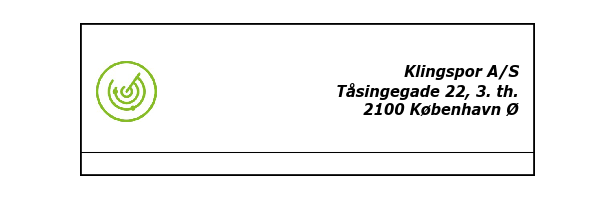

In [432]:
Image.fromarray(addr.headers_hr[0])

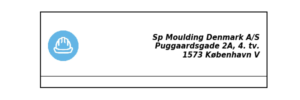

In [420]:
Image.fromarray(addr.headers_lr[0])

In [393]:
414/150

2.76

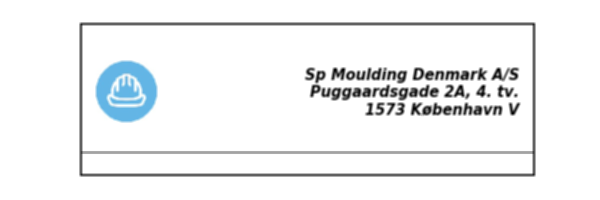

In [423]:
Image.fromarray(cv2.GaussianBlur(addr.headers_hr[0], (3, 3), 2.5))

In [99]:
addr_list[34647]

{'road': 'Pladehals Allé 43, 6. mf.', 'zip': '2450 København SV'}

In [79]:
addr_const(json_addr[245])

{'road': 'Sundby Parkvej 9, 2. th', 'zip': '2300 København S'}

In [33]:

150*4 

600

In [170]:
np.random.choice([1,2,3,4])

array([4, 3, 2, 3, 2])

In [409]:
np.random.rand()

0.02552641896947694